### All imports

In [1]:
import torch
import numpy as np
import pandas as pd
from umap import UMAP
from tqdm import tqdm
from util import EntityType
import matplotlib.pyplot as plt
from torch.nn.functional import cross_entropy
from sklearn.preprocessing import MinMaxScaler
from datasets import load_dataset, Features, ClassLabel
from transformers import AutoTokenizer , AutoModel, pipeline

## Load dataset

In [4]:

path = "../data/dataset/annotated/e2_annotated_short_tagged.json"
dataset = load_dataset("json", data_files=path, split="train")
dataset = dataset.train_test_split(test_size=0.2, seed=42)

Generating train split: 0 examples [00:00, ? examples/s]

# Tokenize the dataset

In [5]:
model_ckpt = 'KB/bert-base-swedish-cased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

In [6]:
#hide_output
token2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(token2ids, key=lambda x: x[-1])

In [7]:
#hide_output
dataset_encoded =  dataset.map(tokenize, batched=True, batch_size=None)
print(dataset_encoded["train"].column_names)

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

['headword', 'QID', 'text', 'entryid', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [8]:
#hide_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [9]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [10]:
#hide_output
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

In [11]:
classes = {t.value: t.name.lower() for t in EntityType}
names = list(classes.values())
features = Features({'label': ClassLabel(num_classes=len(names), names=names)})
features

{'label': ClassLabel(names=['other', 'person', 'location', 'concept'], id=None)}

In [12]:
X_train =  np.array(dataset_hidden["train"]["hidden_state"])
X_test =  np.array(dataset_hidden["test"]["hidden_state"])
# X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])
# y_valid = np.array(dataset_hidden["validation"]["type"])
X_train.shape, X_test.shape

((292, 768), (73, 768))

In [13]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb= pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,9.168394,4.806739,0
1,8.063124,6.249710,1
2,12.462197,6.795166,1
3,10.178985,6.612572,1
4,10.052855,7.133036,1


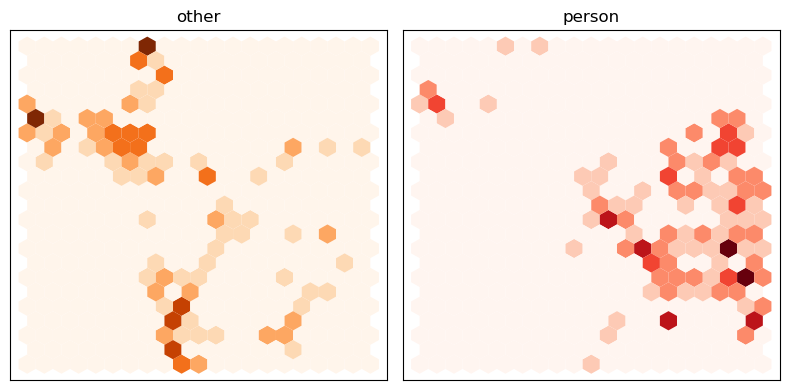

In [12]:
END = 2
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes = axes.flatten()
cmaps = ["Oranges", "Reds", "Greens", "Blues",  "Purples","Greys" ]
labels = features["label"].names
# labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels[:END], cmaps[:END])):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    
    axes[i].set_title(label) 
    axes[i].set_xticks([]), axes[i].set_yticks([])  
    
plt.tight_layout()
plt.show()

In [13]:
def label_int2str(row):
    return features["label"].int2str(row)
    # return dataset["train"].features["label"].int2str(row)

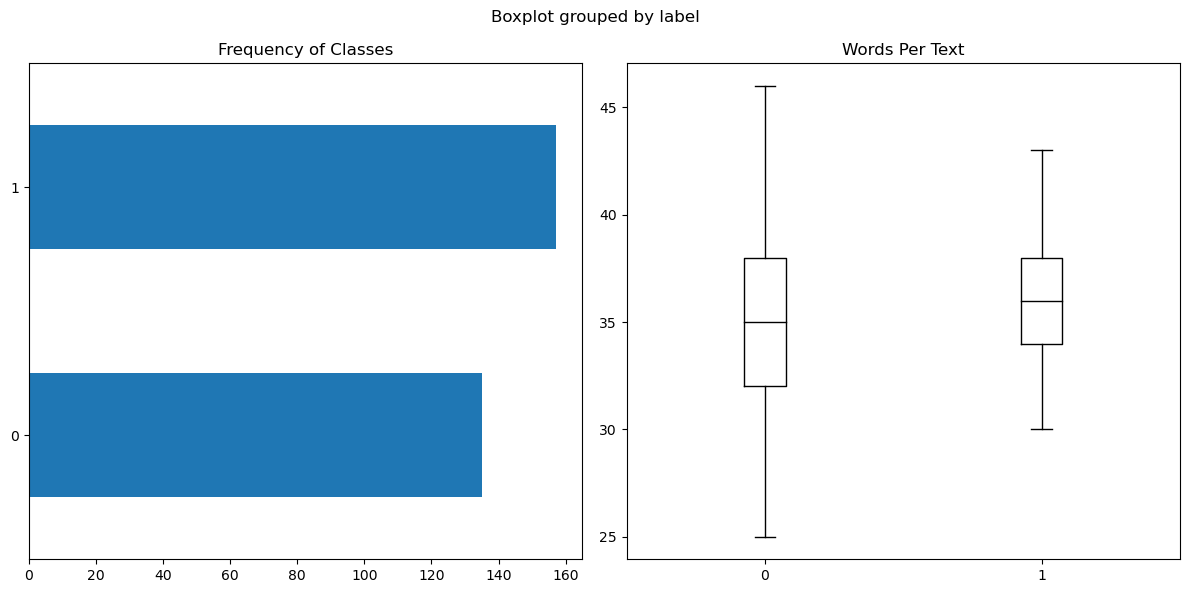

In [14]:
dataset.set_format(type='pandas')
df = dataset["train"][:]
df["label_name"] = df["label"].apply(label_int2str)
df.head()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Frequency of Classes
df["label"].value_counts(ascending=True).plot.barh(ax=axs[0])
axs[0].set_title("Frequency of Classes")

# Plot 2: Words Per Text Boxplot
df["Words Per text"] = df["text"].str.split().apply(len)
df.boxplot("Words Per text", by="label", grid=False, showfliers=False,
                    color="black", ax=axs[1])
axs[1].set_title("Words Per Text")

# Adjust layout and remove xlabel from the boxplot
plt.subplots_adjust(wspace=0.5)
axs[1].set_xlabel("")

# Show the plot
plt.tight_layout()
plt.show()
dataset.reset_format()

## LogisticRegression Model

In [15]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [16]:
lr_clf.score(X_test, y_test)

0.9452054794520548

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.5205479452054794

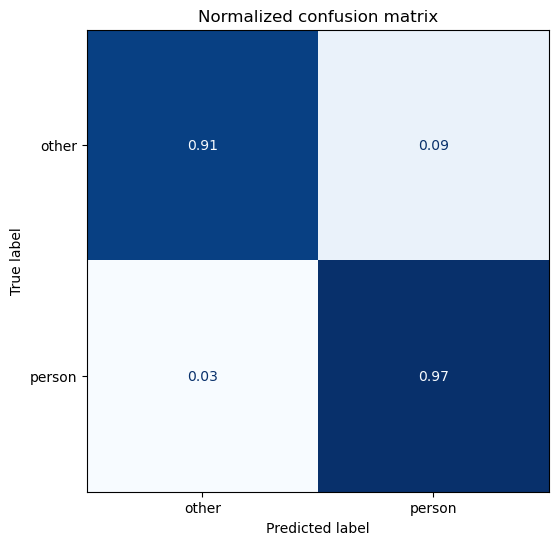

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_test)
plot_confusion_matrix(y_preds, y_test, labels[:END])

## Fine Tune KB-Bert Model

In [19]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

/home/onelock/miniconda3/envs/edap30-gpu/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at KB/bert-base-swedish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define performance metrics

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # f1 = f1_score(labels, preds, average="weighted")
    # f1_micro = f1_score(labels, preds, average='micro')
    f1_macro = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "macro": f1_macro}

In [21]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"models/{model_ckpt}-finetuned2"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.02,#0.04
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [24]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,Macro
1,0.026900,0.278099,0.945205,0.944697
2,0.001700,0.073277,0.986301,0.986260
3,0.043100,0.386922,0.931507,0.930674
4,0.021200,0.098711,0.986301,0.986260
5,0.003200,0.218668,0.972603,0.972598
6,0.012200,0.001318,1.000000,1.000000
7,0.000400,0.005195,1.000000,1.000000
8,0.000300,0.024792,0.986301,0.986260
9,0.000300,0.030704,0.986301,0.986260
10,0.000300,0.031136,0.986301,0.986260


In [25]:
preds_output = trainer.predict(dataset_encoded["test"])
preds_output.metrics

{'test_loss': 0.03113580122590065,
 'test_accuracy': 0.9863013698630136,
 'test_macro': 0.9862601166948992,
 'test_runtime': 0.5169,
 'test_samples_per_second': 141.218,
 'test_steps_per_second': 5.803}

## Save Model 

In [31]:
model_id = "KB_NFBert"
# trainer.save_model(model_id)

## Error analysis summary

In [27]:
def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [28]:
#hide_output
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

dataset_encoded["test"] = dataset_encoded["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

In [29]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
13,"<b>Tor</b>, eng. Se <sp>Dartmoor</sp>, sp. ...",other,person,1.963882
33,"<b>Muraren</b> (fr. <i>Le maçon</i>), komisk o...",other,other,0.154624
66,"<b>Ruthven</b> [ra'thven l. ri'vn], gammal, fö...",other,other,0.130536
11,<b>Baños de Mula</b> [ba'njås -mo'-]. Se <sp>M...,other,other,0.004211
10,"<b>Hiranyakaçipu</b> (eg. ""som har en matta af...",person,person,0.001444
7,"<b>Stolberg</b> [stå'l-], gammal tysk greflig ...",other,other,0.001345
14,<b>*Espö</b> omfattar nu 460 har. 304 inv. (19...,other,other,0.001257
37,<b>Sara</b> var enligt Gamla testamentet Abrah...,person,person,0.001140
53,<b>Nationalföreningen mot emigrationen</b> bil...,other,other,0.001038
16,"<b>Ungern-Sternberg,</b> svensk adlig ätt, som...",other,other,0.000816


# Prediction

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "../model/KB_NFBert"
clf = pipeline("text-classification", model=model_id, device=device)

In [4]:
article = " Sharpe, Mike född 1564 (troligen 23 april; döpt 26 april[2]) i stratford-upon-svon"

clf(article, top_k=1), clf(article.lower(), top_k=1)

([{'label': 'LABEL_1', 'score': 0.9993641972541809}],
 [{'label': 'LABEL_1', 'score': 0.98484206199646}])

### Classifying the Biographical entries of the Encyclopedia 

In [18]:
from util import open_file


file_path = "../data/json/nf/2/e2.json"
data_all = open_file(file_path, 'json')


: 

In [60]:
predictions = []
MAXLENGTH = 256

for data in tqdm(data_all ,desc="Prediction in progress" ,total=len(data_all)):
    article = data['text'][:MAXLENGTH]
    prediction = clf(article, top_k=1)
    predictions.extend(prediction)

Prediction in progress: 100%|██████████| 132568/132568 [2:25:38<00:00, 15.17it/s]  


In [63]:
# from util import save_json
# save_json("../results/predictions.json", predictions)

file saved


In [88]:
y_preds = {'LABEL_0': 0,'LABEL_1': 0}

for prediction in predictions:
    label, score = prediction.values()
    y_preds[label] += 1

y_preds

{'LABEL_0': 101257, 'LABEL_1': 31311}

In [90]:
# from itertools import chain

# predictions = list(chain(*predictions))

     Label   Count
0  LABEL_0  101257
1  LABEL_1   31311


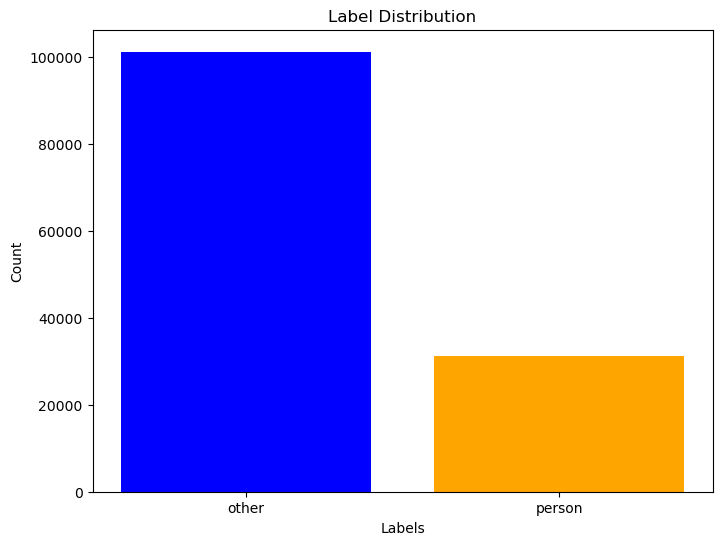

In [89]:
df = pd.DataFrame(list(y_preds.items()), columns=['Label', 'Count'])

print(df)

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(labels[:2], df['Count'], color=['blue', 'orange'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()